In [1]:
%env JAX_PLATFORMS=cpu

env: JAX_PLATFORMS=cpu


In [2]:
from LIMxCMBL.init import *
from LIMxCMBL.kernels import *

from scipy.interpolate import interp1d, LinearNDInterpolator
from scipy.integrate import quad, quad_vec, trapezoid

import sys
from os.path import isfile
import jax
import jax.numpy as jnp

from jax import config
config.update("jax_enable_x64", True)
config.update('jax_platform_name', 'cpu')




Lambda_idx = 24#int(sys.argv[1])
n_external = 301#int(sys.argv[2])
ell_idx = 58#int(sys.argv[3])


Lambda = Lambdas[Lambda_idx]

zmin = 3.5#float(sys.argv[4])
zmax = 8.1#float(sys.argv[5])

kernels = {}
kernels['CII'] = np.array(KI)
kernels['CO'] = np.array(KI_CO)
kernels['Lya'] = np.array(KI_Lya)
kernels['HI'] = np.array(KI_HI)


line_str = 'CII'#sys.argv[6]
print(line_str)
_KI = kernels[line_str]

oup_fname = '/scratch/users/delon/LIMxCMBL/I_auto/comb_'
oup_fname += '%s_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_l_%d_jax_quad.npy'%(line_str,
                                                                                zmin, zmax, 
                                                                                Lambda_idx, 
                                                                                n_external,
                                                                                ell_idx)


print(oup_fname)

chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))


external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)
print('external chi spacing', np.mean(np.diff(external_chis)))

inner_dkparp_integral = np.load('/oak/stanford/orgs/kipac/users/delon/LIMxCMBL/inner_dkparp_integral.npy')
inner_dkparp_integral = inner_dkparp_integral.astype(np.float64)[ell_idx]



@jax.jit
def f_KILo(chi, external_chi, Lambda):
    return (Lambda / jnp.pi 
            * jnp.interp(x = chi, xp = chis, 
                         fp = _KI, left = 0, right = 0) 
            * jnp.sinc(Lambda * (external_chi - chi) / np.pi))



CII
/scratch/users/delon/LIMxCMBL/I_auto/comb_CII_zmin_3.5_zmax_8.1_Lambda_idx_24_n_ext_301_l_58_jax_quad.npy
external chi spacing 7.365126208844301


In [3]:
inner_dkparp_integral.shape

(256, 128)

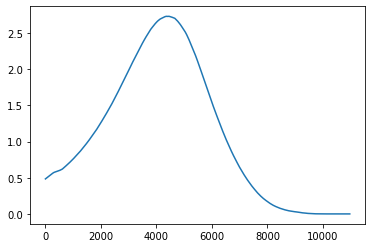

In [4]:
import matplotlib.pyplot as plt
plt.plot(chis, _KI)

In [5]:
f_KILo(5939., 5939., 1.e-2)

Array(0.00512034, dtype=float64)

In [6]:
from interpax import interp2d
from interpax import interp1d as interp1dx

In [7]:
# @jax.jit
# def OLDf_integrand(_chib):
#     #by construction chimin < exteranl_chis < chimax 
#     #I Lo + Lo I
    
#     _delta = jnp.abs(1 - external_chis/_chib) #(n_ext)
#     _delta = jnp.where(_delta < 1e-6, 1e-6, 
#                      jnp.where(_delta > 0.7, 0.7, _delta))
    
#     _idx = ((chimin <= 2*_chib - external_chis) 
#             & (2*_chib - external_chis <= chimax)) #(n_ext)
    
#     cross_integrand = (2 * jnp.interp(x = external_chis, xp = chis, fp = _KI, left = 0, right = 0) 
#                        * interp2d(xq = _chib, yq=jnp.log(_delta), 
#                            x = chibs, y = jnp.log(deltas), f=inner_dkparp_integral,
#                            method='linear',) 
#                        / (_chib**2))
    
#     cross_integrand = jnp.where(_idx.reshape(-1, 1),
#                                cross_integrand.reshape(-1, 1)
#                                * f_KILo(2*_chib - external_chis.reshape(-1,1), 
#                                         external_chi = external_chis.reshape(1, -1), 
#                                         Lambda=Lambda),
#                                 0)
#     cross_integrand = cross_integrand + jnp.moveaxis(cross_integrand, -1, -2) # the two cross terms are just from switching chi and chi'
#     #LoLo
#     plus = _chib*(1+deltas)
#     mins = _chib*(1-deltas)
#     _idxs = (chimin < plus) & (plus < chimax) & (chimin < mins) & (mins < chimax)
    
#     LoLo_integrand  = jnp.where(_idxs,
#                                f_KILo(plus, 
#                                       external_chi = external_chis.reshape(-1, 1, 1), 
#                                       Lambda=Lambda) 
#                                 * f_KILo(mins, 
#                                          external_chi = external_chis.reshape(1, -1, 1), 
#                                          Lambda=Lambda),
#                                0)
#     LoLo_integrand += jnp.where(_idxs,
#                                f_KILo(mins, 
#                                       external_chi = external_chis.reshape(-1, 1, 1), 
#                                       Lambda=Lambda) 
#                                 * f_KILo(plus, 
#                                          external_chi = external_chis.reshape(1, -1, 1), 
#                                          Lambda=Lambda),0)
#     LoLo_integrand *= (2 / _chib) #(x,y,d)
#     LoLo_integrand = jnp.einsum('xyd,d->xyd', LoLo_integrand, deltas)
#     LoLo_integrand = jnp.einsum('xyd,d->xyd', LoLo_integrand, 
#                                 interp1dx(xq = _chib,
#                                          x = chibs, f=inner_dkparp_integral,
#                                          method='linear',))
    
#     LoLo_integrand = jnp.trapezoid(x = np.log(deltas), y = LoLo_integrand, axis=-1)
#     return LoLo_integrand - cross_integrand

# OLDf_integrand((chimin + chimax)/2)[0, 58]

In [8]:
from tqdm import trange

In [9]:
# res, tmp = quad_vec(f_integrand, 10, chimax_sample,
#                    epsabs = 0.0, epsrel=1e-3)


In [10]:
# plt.imshow(res)

In [17]:
oup = np.zeros((n_external, n_external))
for chi_idx in trange(n_external):
    chi = external_chis[chi_idx]
    chip = external_chis[chi_idx:]
    
    @jax.jit
    def f_integrand(_chib):
        _delta = jnp.abs(1 - chi/_chib) #(1)
        _delta = jnp.where(_delta < 1e-6, 1e-6, 
                         jnp.where(_delta > 0.7, 0.7, _delta))

        _idx = ((chimin <= 2*_chib - chi) 
                & (2*_chib - chi <= chimax)) #(1)

        cross_integrand = (2 * jnp.interp(x = chi, xp = chis, fp = _KI, left = 0, right = 0) 
                           * interp2d(xq = _chib, yq=jnp.log(_delta), 
                               x = chibs, y = jnp.log(deltas), f=inner_dkparp_integral,
                               method='linear',) 
                           / (_chib**2))
        
        
        asdfasdf = jnp.where(_idx,
                                   cross_integrand
                                   * f_KILo(2*_chib - chi, 
                                            external_chi = chip,
                                            Lambda=Lambda),
                                    0) #(p)
        print(1, asdfasdf.shape)


        cross_integrand = jnp.where(_idx,
                                   cross_integrand.reshape(-1, 1)
                                   * f_KILo(2*_chib - chi, 
                                            external_chi = chip,
                                            Lambda=Lambda),
                                    0) #(p)
        
        print(2, cross_integrand.shape)
        
        _delta = jnp.abs(1 - chip/_chib) #(p)
        _delta = jnp.where(_delta < 1e-6, 1e-6, 
                         jnp.where(_delta > 0.7, 0.7, _delta))

        _idx = ((chimin <= 2*_chib - chip) 
                & (2*_chib - chip <= chimax)) #(p)


        cross_integrand_2 = (2 * jnp.interp(x = chip, xp = chis, fp = _KI, left = 0, right = 0) 
                           * interp2d(xq = _chib, yq=jnp.log(_delta), 
                               x = chibs, y = jnp.log(deltas), f=inner_dkparp_integral,
                               method='linear',) 
                           / (_chib**2))

        cross_integrand_2 = jnp.where(_idx,
                                   cross_integrand_2
                                   * f_KILo(2*_chib - chip, 
                                            external_chi = chi,
                                            Lambda=Lambda),
                                    0)
        print(3, cross_integrand_2.shape)
        cross_integrand += cross_integrand_2
        print(4, cross_integrand.shape)
        #LoLo
        plus = _chib*(1+deltas)
        mins = _chib*(1-deltas)
        _idxs = (chimin < plus) & (plus < chimax) & (chimin < mins) & (mins < chimax)

        LoLo_integrand  = jnp.where(_idxs,
                                   f_KILo(plus, 
                                          external_chi = chi,
                                          Lambda=Lambda) 
                                    * f_KILo(mins, 
                                             external_chi = chip.reshape(-1, 1),
                                             Lambda=Lambda),
                                   0)
        LoLo_integrand += jnp.where(_idxs,
                                   f_KILo(mins, 
                                          external_chi = chi,
                                          Lambda=Lambda) 
                                    * f_KILo(plus, 
                                             external_chi = chip.reshape(-1, 1),
                                             Lambda=Lambda),0)
        LoLo_integrand *= (2 / _chib) #(p,d)
        LoLo_integrand = jnp.einsum('pd,d->pd', LoLo_integrand, deltas)
        LoLo_integrand = jnp.einsum('pd,d->pd', LoLo_integrand, 
                                    interp1dx(xq = _chib,
                                             x = chibs, f=inner_dkparp_integral,
                                             method='linear',))

        LoLo_integrand = jnp.trapezoid(x = np.log(deltas), y = LoLo_integrand, axis=-1)
        print((LoLo_integrand - cross_integrand).shape)
        return LoLo_integrand - cross_integrand
    if(chi_idx==0):
        print(f_integrand((chimin + chimax)/2)[58])
        

#     ret, _, info = quad_vec(f_integrand, 10, chimax_sample,
#                             points=[(chimin + chi)/2, (chimax + chi)/2],
#                             epsabs=0.0, epsrel=1e-3, full_output=True)
#     print(info.success, info.status, info.message)
#     print('ninters', info.intervals.shape)

#     oup[chi_idx,chi_idx:] = ret

# for chi_idx in trange(n_external):
#     for chip_idx in range(n_external):
#         oup[chip_idx,chi_idx] = oup[chi_idx,chip_idx]

  0%|          | 0/301 [00:00<?, ?it/s]

1 (301,)
2 (1, 301)
3 (301,)
4 (1, 301)
(1, 301)


100%|██████████| 301/301 [00:00<00:00, 333.26it/s]

[-1.07876311e-13 -3.47383310e-13 -4.08843383e-13 -2.57766672e-13
  2.99185086e-14  3.05964754e-13  4.26148484e-13  3.25568447e-13
  5.36142689e-14 -2.50195604e-13 -4.27734733e-13 -3.84513312e-13
 -1.39898510e-13  1.81344751e-13  4.12628205e-13  4.31866795e-13
  2.25854583e-13 -1.01220359e-13 -3.80395917e-13 -4.65152212e-13
 -3.08238740e-13  1.21346373e-14  3.31186633e-13  4.82245034e-13
  3.83739168e-13  8.31399793e-14 -2.65766612e-13 -4.81475616e-13
 -4.49100161e-13 -1.81461998e-13  1.85498326e-13  4.61677414e-13
  5.01200234e-13  2.79369910e-13 -9.23632114e-14 -4.22284958e-13
 -5.37189331e-13 -3.73203292e-13 -1.10934713e-14  3.63362699e-13
  5.54576704e-13  4.59192849e-13  1.21798068e-13 -2.85650460e-13
 -5.51339610e-13 -5.33582025e-13 -2.36225629e-13  1.90566054e-13
  5.25999383e-13  5.92730295e-13  3.50468670e-13 -8.02150947e-14
 -4.77713327e-13 -6.33247108e-13 -4.60351350e-13 -4.26540064e-14
  4.06308876e-13  6.52074736e-13  5.61505292e-13  1.74663450e-13
 -3.12357470e-13 -6.46625

In [14]:
# oup = np.zeros((n_external, n_external))
# for chi_idx in trange(n_external):
#     chi = external_chis[chi_idx]
#     chip = external_chis[chi_idx:]
    
#     @jax.jit
#     def f_integrand(_chib):
#         _delta = jnp.abs(1 - chi/_chib) #(1)
#         _delta = jnp.where(_delta < 1e-6, 1e-6, 
#                          jnp.where(_delta > 0.7, 0.7, _delta))

#         _idx = ((chimin <= 2*_chib - chi) 
#                 & (2*_chib - chi <= chimax)) #(1)

#         cross_integrand = (2 * jnp.interp(x = chi, xp = chis, fp = _KI, left = 0, right = 0) 
#                            * interp2d(xq = _chib, yq=jnp.log(_delta), 
#                                x = chibs, y = jnp.log(deltas), f=inner_dkparp_integral,
#                                method='linear',) 
#                            / (_chib**2))

#         cross_integrand = jnp.where(_idx,
#                                    cross_integrand.reshape(-1, 1)
#                                    * f_KILo(2*_chib - chi, 
#                                             external_chi = chip,
#                                             Lambda=Lambda),
#                                     0) #(p)
        
        
#         _delta = jnp.abs(1 - chip/_chib) #(p)
#         _delta = jnp.where(_delta < 1e-6, 1e-6, 
#                          jnp.where(_delta > 0.7, 0.7, _delta))

#         _idx = ((chimin <= 2*_chib - chip) 
#                 & (2*_chib - chip <= chimax)) #(p)


#         cross_integrand_2 = (2 * jnp.interp(x = chip, xp = chis, fp = _KI, left = 0, right = 0).reshape(1,-1) 
#                            * interp2d(xq = _chib, yq=jnp.log(_delta), 
#                                x = chibs, y = jnp.log(deltas), f=inner_dkparp_integral,
#                                method='linear',).reshape(-1, len(chip)) 
#                            / (_chib**2)) #(l, p)
#         cross_integrand_2 = jnp.where(_idx.reshape(1, -1),
#                                    cross_integrand_2
#                                    * f_KILo(2*_chib - chip, 
#                                             external_chi = chi,
#                                             Lambda=Lambda).reshape(1, -1),
#                                     0)
#         cross_integrand += cross_integrand_2
        
#         #LoLo
#         plus = _chib*(1+deltas)
#         mins = _chib*(1-deltas)
#         _idxs = (chimin < plus) & (plus < chimax) & (chimin < mins) & (mins < chimax)

#         LoLo_integrand  = jnp.where(_idxs,
#                                    f_KILo(plus, 
#                                           external_chi = chi,
#                                           Lambda=Lambda) 
#                                     * f_KILo(mins, 
#                                              external_chi = chip.reshape(-1, 1),
#                                              Lambda=Lambda),
#                                    0)
#         LoLo_integrand += jnp.where(_idxs,
#                                    f_KILo(mins, 
#                                           external_chi = chi,
#                                           Lambda=Lambda) 
#                                     * f_KILo(plus, 
#                                              external_chi = chip.reshape(-1, 1),
#                                              Lambda=Lambda),0)
#         LoLo_integrand *= (2 / _chib) #(p,d)
#         LoLo_integrand = jnp.einsum('pd,d->pd', LoLo_integrand, deltas)
#         LoLo_integrand = jnp.einsum('pd,dl->lpd', LoLo_integrand, 
#                                     interp1dx(xq = _chib,
#                                              x = chibs, f=inner_dkparp_integral,
#                                              method='linear',))

#         LoLo_integrand = jnp.trapezoid(x = np.log(deltas), y = LoLo_integrand, axis=-1)
#         return LoLo_integrand - cross_integrand
# #     if(chi_idx==0):
# #         print(f_integrand((chimin + chimax)/2)[58])
        

#     ret, _, info = quad_vec(f_integrand, 10, chimax_sample,
#                             points=[(chimin + chi)/2, (chimax + chi)/2],
#                             epsabs=0.0, epsrel=1e-3, full_output=True)
#     print(info.success, info.status, info.message)
#     print('ninters', info.intervals.shape)

#     oup[:,chi_idx,chi_idx:] = ret

# for chi_idx in trange(n_external):
#     for chip_idx in range(n_external):
#         oup[:,chip_idx,chi_idx] = oup[:,chi_idx,chip_idx]

In [ ]:
# cross = np.zeros((100, n_external, n_external), dtype=np.float64)
# for chi_idx in trange(n_external):
#     chi = external_chis[chi_idx]
#     chip = external_chis[chi_idx:]
    
#     def f_integrand(_chib):
#         _delta = np.abs(1 - chi/_chib)
#         _delta = min(0.7, max(1e-6, _delta))
#         integrand = 2 * np.interp(x = chi, xp = chis, fp = _KI, left = 0, right = 0)
#         integrand *= f_inner_integral((_chib, np.log10(_delta)))
#         integrand /= (_chib**2)
#         kernel = f_KILo(2*_chib - chi,
#                         external_chi = chip,
#                         Lambda=Lambda)
#         integrand = np.einsum('l,p->lp', integrand, kernel)
#         return integrand

#     ret, _ = quad_vec(f_integrand, (chimin + chi)/2, (chimax + chi)/2,
#             epsabs=0.0, epsrel=1e-3)#, workers = 32)
#     cross[:,chi_idx,chi_idx:] = ret
# # then move axis

# for chi_idx in trange(n_external):
#     for chip_idx in range(n_external):
#         cross[:,chip_idx,chi_idx] = cross[:,chi_idx,chip_idx]

# cross = cross + np.moveaxis(cross, -1, -2) # the two cross terms are just from switching chi and chi'